In [ ]:
# import Pkg; Pkg.add("JuMPeR")
# Pkg.add("Compat")
# import Pkg; Pkg.add("Ipopt")

In [118]:
using CSV, DataFrames
using JuMP, Gurobi
#using JuMPeR
using Ipopt
using Plots

# using IpoptSolver

In [2]:
retail = "./Data/generated_data_complete.csv" #468×13 DataFrame
retail = DataFrame(CSV.File(retail));
retail

Row,Column1,product_id,month,qty,freight_price,unit_price,customers,comp_1,fp1,comp_2,fp2,comp_3,fp3
,Int64,String15,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,11,bed1,1,5.0,13.6219,41.2668,88.0,88.9405,21.1437,143.089,18.377,44.0345,13.8498
2,10,bed1,2,6.0,13.4136,41.6165,56.0,89.8649,16.9539,83.4357,19.5907,45.4928,14.7841
3,8,bed1,3,10.0,14.1062,43.6091,120.0,89.2926,19.3734,62.9036,22.6992,44.6849,12.9731
4,9,bed1,4,7.0,13.0714,45.7578,52.0,89.7734,19.5056,158.042,19.6394,42.6914,13.2125
5,0,bed1,5,1.0,15.1,45.95,57.0,89.9,15.0119,215.0,8.76,45.95,15.1
6,1,bed1,6,3.0,12.9333,45.95,61.0,89.9,14.7692,209.0,21.322,45.95,12.9333
7,2,bed1,7,6.0,14.84,45.95,123.0,89.9,13.9938,205.0,22.1959,45.95,14.84
8,3,bed1,8,4.0,14.2875,45.95,90.0,89.9,14.6568,199.51,19.4129,45.95,14.2875
9,4,bed1,9,2.0,15.1,45.95,54.0,89.9,18.7765,163.399,24.3247,45.95,15.1


In [3]:
num_rows = size(retail)[1] # 468
num_month = 12
num_product = length(unique(retail[!,"product_id"])) # 
print("There are ", num_product, " number of product")

There are 39 number of product

In [4]:
demand = retail[!,"customers"]
cost = retail[!,"freight_price"]

C1 = retail[!,"comp_1"]
C2 = retail[!,"comp_2"]
C3 = retail[!,"comp_3"]

com1_cost = retail[!,"fp1"]
com2_cost = retail[!,"fp2"]
com3_cost = retail[!,"fp3"];

In [39]:
ori_price = retail[!,"unit_price"]
ori_price = reshape(ori_price, 12, 39)  # Reshape by column (12 columns, 39 rows)
ori_price = permutedims(ori_price)

39×12 Matrix{Float64}:
  41.2668   41.6165   43.6091   45.7578  …   45.95     40.5318   39.99
  89.64     89.9      89.9      89.9         89.9      89.9      88.4882
 167.679   195.451   189.648   208.187      166.636   188.662   180.819
 104.113   109.512    95.7228   98.6572      98.9      98.9      98.9
 150.016   154.242   167.137   157.994      137.9     137.9     134.9
 140.036   159.99    159.99    139.99    …  154.696   149.99    149.99
  23.693    21.6806   21.6762   22.6455      21.5429   24.5      24.5
  20.8786   20.8602   20.9902   23.5694      20.6667   24.5      24.5
  99.5182   85.7043   99.99     99.99        99.99     99.99     99.99
 125.526   126.937   129.99    129.99       119.99    129.99    129.99
 149.323   154.875   154.526   146.795   …  146.99    157.36    166.99
  99.99     99.99     99.99     99.99        99.99     99.99     99.99
  37.9739   36.9309   38.1177   37.1977      38.4      36.8543   37.8462
   ⋮                                     ⋱           

In [5]:
demand = reshape(demand, 12, 39)  # Reshape by column (12 columns, 39 rows)
demand = permutedims(demand)  # Reshape by row

cost = reshape(cost, 12, 39)  # Reshape by column (12 columns, 39 rows)
cost = permutedims(cost)  # Reshape by row

C1 = reshape(C1, 12, 39)  # Reshape by column (12 columns, 39 rows)
C1 = permutedims(C1)  # Reshape by row

C2 = reshape(C2, 12, 39)  # Reshape by column (12 columns, 39 rows)
C2 = permutedims(C2)  # Reshape by row

C3 = reshape(C3, 12, 39)  # Reshape by column (12 columns, 39 rows)
C3 = permutedims(C3);  # Reshape by row

# Optimization Model 1

In [155]:
function model1()
    model = Model(Ipopt.Optimizer)

    @variable(model, Z[1:num_product,0:num_month] >= 0)
    
    @NLobjective(model, Max, 
        sum(sum((Z[i,t]-cost[i,t])*(demand[i,t]*exp(-(3*Z[i,t]/(C1[i,t]+C2[i,t]+C3[i,t])))^2) for i in 1:num_product) for t in 1:num_month))

    @constraint(model, [i in 1:num_product], Z[i,0] == ori_price[i,1])
    for t in 1:num_month
        @constraint(model, [i in 1:num_product], Z[i,t] <= 1.05*Z[i,t-1])
        #@constraint(model,sum(Z[i,t] for i in 1:num_product)==150)
    end
    
    optimize!(model);
    objective = objective_value(model)
    return objective, value.(Z)
end
out = model1();

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:       39
Number of nonzeros in inequality constraint Jacobian.:      936
Number of nonzeros in Lagrangian Hessian.............:      468

Total number of variables............................:      507
                     variables with only lower bounds:      507
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       39
Total number of inequality constraints...............:      468
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      468

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -7.3452478e+05 3.50e+02 6.83e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [156]:
obj, Z = out
print("the maximum revenue with optimized pricing is ", Int(round(obj, digits=0)), "\n")
Z

the maximum revenue with optimized pricing is 301751


2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, Base.OneTo(39)
    Dimension 2, 0:12
And data, a 39×13 Matrix{Float64}:
  41.2668   43.3302   45.4967   47.7715  …   45.4      44.3267   43.308
  89.64     55.8963   58.6911   61.6257      59.1971   53.016    55.0594
 167.679    79.4095   74.8114   71.4089      68.3895   63.8506   63.6194
 104.113    71.8935   69.5343   71.442       75.8718   75.9383   73.5083
 150.016   103.36    108.528   110.238      106.9     105.697   104.578
 140.036   118.677   113.395   113.395   …  121.229   110.831   106.883
  23.693    24.8776   26.1215   26.6849      24.4624   25.6855   25.1237
  20.8786   21.9226   22.92     23.0908      24.1224   25.3286   25.7747
  99.5182   62.3601   65.4781   68.752       67.6881   71.0725   70.2617
 125.526    77.9771   81.876    78.7738      77.8466   81.7389   85.585
 149.323    82.8572   80.764    82.7039  …   81.2437   85.3058   89.5711
  99.99     67.3526   64.0865   67.2908      69.240

In [159]:
opt_price = DataFrame(collect(Z),:auto)[!,2:13];

## Simple Model

In [23]:
function model2()
    model = Model(Gurobi.Optimizer);
    @variable(model, z[1:num_rows] >= 0)
    
    @objective(model, Max, 
        sum((z[i]-cost[i])*(demand[i]/4) for i in 1:num_rows))
    
    @constraint(model, [i in 1:num_rows], z[i] <= C3[i])
    
    optimize!(model);
    objective = objective_value(model)
    return objective, value.(z)
end
out = model2();

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 468 rows, 468 columns and 468 nonzeros
Model fingerprint: 0x870f2072
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+02]
Presolve removed 468 rows and 468 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8381389e+05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.838138899e+05

User-callback calls 32, time in user-callback 0.00 sec


## Baseline Model

In [30]:
size(retail)[1]

468

In [157]:
baseline_rev = 0
for i in 1:size(retail)[1]
    # print()
    total_demand = retail[i,"customers"]
    baseline_price = retail[i,"unit_price"]
    baseline_cost = retail[i,"freight_price"]
    comp1_price = retail[i,"comp_1"]
    comp2_price = retail[i,"comp_2"]
    comp3_price = retail[i,"comp_3"]
    #sum(sum((Z[i,t]-cost[i,t])*(demand[i,t]*exp(-(Z[i,t]/(C1[i,t]+C2[i,t]+C3[i,t])))^2) for i in 1:num_product) for t in 1:num_month))

    baseline_sale = total_demand*exp(-3*baseline_price/(comp1_price+comp2_price+comp3_price))^2
    #print(baseline_sale, "\n")
    baseline_profit = baseline_price-baseline_cost
    
    baseline_rev+=baseline_profit*baseline_sale
end


In [158]:
baseline_rev

221008.3479587794

In [160]:
ori_price

39×12 Matrix{Float64}:
  41.2668   41.6165   43.6091   45.7578  …   45.95     40.5318   39.99
  89.64     89.9      89.9      89.9         89.9      89.9      88.4882
 167.679   195.451   189.648   208.187      166.636   188.662   180.819
 104.113   109.512    95.7228   98.6572      98.9      98.9      98.9
 150.016   154.242   167.137   157.994      137.9     137.9     134.9
 140.036   159.99    159.99    139.99    …  154.696   149.99    149.99
  23.693    21.6806   21.6762   22.6455      21.5429   24.5      24.5
  20.8786   20.8602   20.9902   23.5694      20.6667   24.5      24.5
  99.5182   85.7043   99.99     99.99        99.99     99.99     99.99
 125.526   126.937   129.99    129.99       119.99    129.99    129.99
 149.323   154.875   154.526   146.795   …  146.99    157.36    166.99
  99.99     99.99     99.99     99.99        99.99     99.99     99.99
  37.9739   36.9309   38.1177   37.1977      38.4      36.8543   37.8462
   ⋮                                     ⋱           

In [161]:
opt_price

Row,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,43.3302,45.4967,47.7715,50.1601,52.6681,55.3015,58.0666,60.9699,64.0184,45.4,44.3267,43.308
2,55.8963,58.6911,61.6257,64.707,67.9423,71.3395,70.8022,70.5501,68.6513,59.1971,53.016,55.0594
3,79.4095,74.8114,71.4089,66.8111,70.1517,73.6593,77.3422,75.3062,74.1995,68.3895,63.8506,63.6194
4,71.8935,69.5343,71.442,72.1495,69.9852,73.4844,71.98,71.3074,73.2733,75.8718,75.9383,73.5083
5,103.36,108.528,110.238,102.446,107.568,98.3165,92.3445,96.9617,101.81,106.9,105.697,104.578
6,118.677,113.395,113.395,105.695,110.979,116.528,118.103,111.718,117.304,121.229,110.831,106.883
7,24.8776,26.1215,26.6849,26.5634,26.0028,26.656,24.4538,25.6765,26.0833,24.4624,25.6855,25.1237
8,21.9226,22.92,23.0908,23.3145,24.4732,24.7427,23.7641,24.9523,25.3611,24.1224,25.3286,25.7747
9,62.3601,65.4781,68.752,69.1974,70.0159,68.8214,71.5241,71.7929,64.4648,67.6881,71.0725,70.2617


## Plots

In [215]:

for row in [1,14,27]
    plot1 = plot(1:12, collect(values(opt_price[row,:])), label="Optimized_Pricing", xlabel="Month", ylabel="Price", 
        title="Optimized vs Baseline vs Competitor Pricing for Product $row", legendfont=6, titlefont=10)
    plot!(1:12, collect(values(C1[row,:])), label="Competitor1_Pricing")
    plot!(1:12, collect(values(C2[row,:])), label="Competitor2_Pricing")
    plot!(1:12, collect(values(C3[row,:])), label="Competitor3_Pricing")
    plot!(1:12, collect(values(ori_price[row,:])), label="Baseline_Pricing")
    #savefig("plot_$row.pdf")
    savefig("product_$row opt_baseline_comp.png")
end


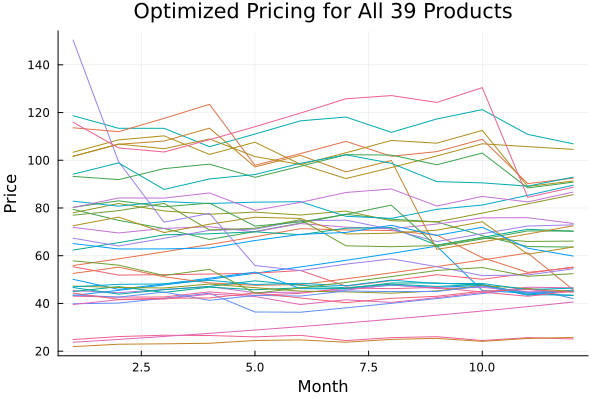

"C:\\Users\\nuobe\\Desktop\\MITclass_Optimization\\Project\\all_product_opt_price.png"

In [208]:
plot(legend=-1)
for row in 1:39
    plot!(1:12, collect(values(opt_price[row,:])), label="Line Plot", xlabel="Month", ylabel="Price", title="Optimized Pricing for All 39 Products")
end
display(plot!())
savefig("all_product_opt_price.png")